In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_squared_error
import os
from sampler import ImbalancedDatasetSampler

In [2]:
fileNames = os.listdir('../Data')
newFileNames = []
outputFileNames = os.listdir('OriVectUsers/')

for name in fileNames:
    if 'User' in name:
        newFileNames.append(name)
        
newFileNames.sort()
outputFileNames.sort()

test_X_fName = newFileNames.pop(len(newFileNames)-1)

test_y_fName = outputFileNames.pop(len(outputFileNames)-1)

In [3]:
def centAndScale(magData):

    x = [float(row[0]) for row in magData]
    y = [float(row[1]) for row in magData]
    z = [float(row[2]) for row in magData]

    plt.scatter(x, y, label='XY')
    plt.scatter(x, z, label='XZ')
    plt.scatter(y, z, label='YZ')

    plt.xlabel('x label')
    plt.ylabel('y label')

    plt.show()

    offset_x = (max(x) + min(x)) / 2
    offset_y = (max(y) + min(y)) / 2
    offset_z = (max(z) + min(z)) / 2

    corrected_mag_data = np.array([[0, 0, 0]])

    for row in magData:

        corrected_x = float(row[0]) - offset_x
        corrected_y = float(row[1]) - offset_y
        corrected_z = float(row[2]) - offset_z

        corr_list = np.array([corrected_x, corrected_y, corrected_z])
        corr_list = corr_list.reshape((1, 3))

        corrected_mag_data = np.append(corrected_mag_data, corr_list, axis=0)

    corrected_mag_data = corrected_mag_data[1:]

    plt.scatter(corrected_mag_data[:, 0], corrected_mag_data[:, 1], label='XY')
    plt.scatter(corrected_mag_data[:, 0], corrected_mag_data[:, 2], label='XZ')
    plt.scatter(corrected_mag_data[:, 1], corrected_mag_data[:, 2], label='YZ')

    plt.xlabel('x label')
    plt.ylabel('y label')

    plt.show()

    norm_corr_mag_data = Normalizer().fit_transform(corrected_mag_data)

    return norm_corr_mag_data

In [4]:
def parseSheet(userSheetName, outputSheetName, test=False):
    
    user = pd.read_csv(userSheetName)
    userOutput = pd.read_excel(outputSheetName, header=None)

    user.drop(user.columns[[3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16]], axis=1, inplace=True)

    cols = user.columns.tolist()

    userAcc = np.asarray(user[['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)', 'ACCELEROMETER Z (m/s²)']].values)
    userMag = np.asarray(user[['MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)', 'MAGNETIC FIELD Z (μT)']].values)
    
    userMag = centAndScale(userMag)
    
    userTensor = np.concatenate((userAcc, userMag), axis=1)
    
    userTensorOut = userOutput.values
    X = torch.as_tensor(userTensor).float()
    y = torch.as_tensor(userTensorOut).float()

    train = torch.utils.data.TensorDataset(X, y)
    
    return (train, X, y)

In [14]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, layer_size, output_size):

        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.layer_size = layer_size

        # self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=layer_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):

        hidden = self.init_hidden(X)

        out, hidden = self.rnn(X, hidden)

        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, X):

        return torch.zeros(self.layer_size, X.shape[0], self.hidden_size).float()

In [24]:
input_dim = 6
hidden_dim = 6
layer_dim = 1
output_dim = 6

rnn = RNN(input_dim, hidden_dim, layer_dim, output_dim)

error = nn.MSELoss()

learning_rate = 0.1

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

count = 0

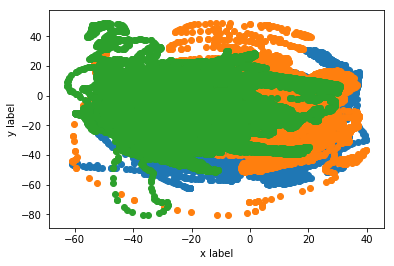

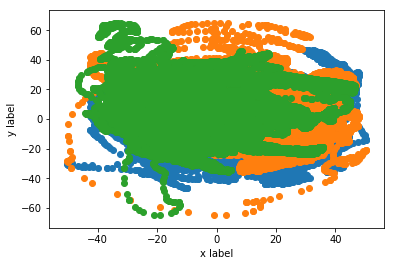

25
Output: tensor([ 0.9351, -0.5030, -0.0058,  0.0775,  0.1934,  0.9656],
       grad_fn=<SelectBackward>)
True: tensor([ 0.7970, -0.6039,  0.0086,  0.1655,  0.2320,  0.9585])
Loss: 0.012213263660669327

Output: tensor([ 0.9389, -0.4976, -0.0067,  0.0685,  0.1888,  0.9732],
       grad_fn=<SelectBackward>)
True: tensor([ 0.7970, -0.6039,  0.0086,  0.1655,  0.2320,  0.9585])
Loss: 0.013054021634161472

Output: tensor([ 0.9416, -0.4991, -0.0046,  0.0651,  0.1875,  0.9701],
       grad_fn=<SelectBackward>)
True: tensor([ 0.7970, -0.6039,  0.0086,  0.1655,  0.2320,  0.9585])
Loss: 0.013377453200519085

Output: tensor([ 0.9423, -0.5047,  0.0072,  0.0640,  0.1869,  0.9582],
       grad_fn=<SelectBackward>)
True: tensor([ 0.7970, -0.6039,  0.0086,  0.1655,  0.2320,  0.9585])
Loss: 0.013307546265423298

Output: tensor([ 0.9420, -0.5141,  0.0265,  0.0639,  0.1868,  0.9414],
       grad_fn=<SelectBackward>)
True: tensor([ 0.7970, -0.6039,  0.0086,  0.1655,  0.2320,  0.9585])
Loss: 0.013083023950

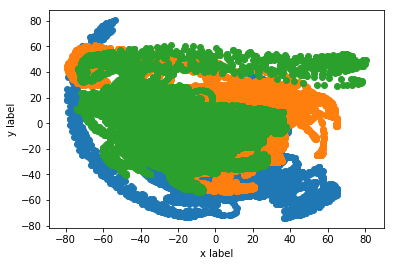

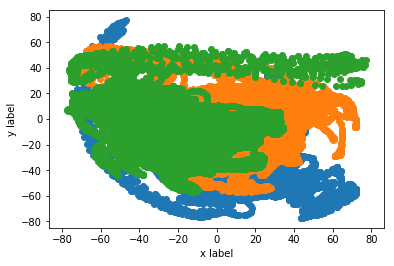

22
Output: tensor([-0.4099, -0.9187, -0.0448,  0.3444, -0.1623,  0.8837],
       grad_fn=<SelectBackward>)
True: tensor([-0.4694, -0.8805, -0.0665,  0.5246, -0.3386,  0.7811])
Loss: 0.01517709344625473

Output: tensor([-0.4180, -0.9391, -0.0172,  0.3511, -0.1504,  0.8694],
       grad_fn=<SelectBackward>)
True: tensor([-0.4694, -0.8805, -0.0665,  0.5246, -0.3386,  0.7811])
Loss: 0.015923261642456055

Output: tensor([-0.4185, -0.9481, -0.0048,  0.3570, -0.1442,  0.8622],
       grad_fn=<SelectBackward>)
True: tensor([-0.4694, -0.8805, -0.0665,  0.5246, -0.3386,  0.7811])
Loss: 0.016371075063943863

Output: tensor([-0.4181, -0.9501, -0.0026,  0.3598, -0.1422,  0.8612],
       grad_fn=<SelectBackward>)
True: tensor([-0.4694, -0.8805, -0.0665,  0.5246, -0.3386,  0.7811])
Loss: 0.016478780657052994

Output: tensor([-0.4184, -0.9505, -0.0030,  0.3616, -0.1415,  0.8614],
       grad_fn=<SelectBackward>)
True: tensor([-0.4694, -0.8805, -0.0665,  0.5246, -0.3386,  0.7811])
Loss: 0.0164499543607

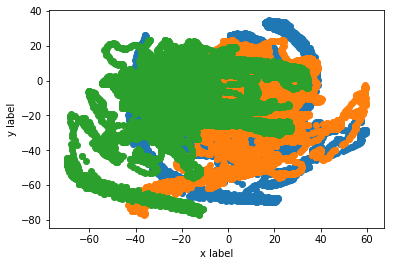

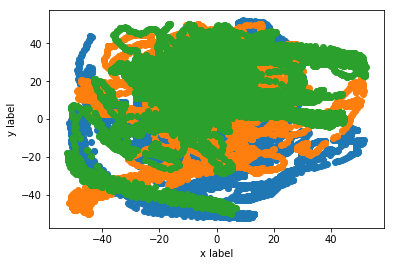

25
Output: tensor([ 0.5843,  0.8462, -0.0485, -0.3159,  0.2106,  0.9149],
       grad_fn=<SelectBackward>)
True: tensor([ 0.6071,  0.6777, -0.4149, -0.0793,  0.5712,  0.8170])
Loss: 0.04341251775622368

Output: tensor([ 0.5458,  0.8328, -0.1447, -0.3251,  0.2153,  0.9783],
       grad_fn=<SelectBackward>)
True: tensor([ 0.6071,  0.6777, -0.4149, -0.0793,  0.5712,  0.8170])
Loss: 0.03615177050232887

Output: tensor([ 0.5849,  0.8158, -0.1655, -0.3238,  0.2328,  0.9795],
       grad_fn=<SelectBackward>)
True: tensor([ 0.6071,  0.6777, -0.4149, -0.0793,  0.5712,  0.8170])
Loss: 0.03122139535844326

Output: tensor([ 0.6162,  0.8065, -0.1711, -0.3208,  0.2464,  0.9735],
       grad_fn=<SelectBackward>)
True: tensor([ 0.6071,  0.6777, -0.4149, -0.0793,  0.5712,  0.8170])
Loss: 0.028444955125451088

Output: tensor([ 0.6354,  0.8014, -0.1714, -0.3190,  0.2528,  0.9685],
       grad_fn=<SelectBackward>)
True: tensor([ 0.6071,  0.6777, -0.4149, -0.0793,  0.5712,  0.8170])
Loss: 0.027053210884332

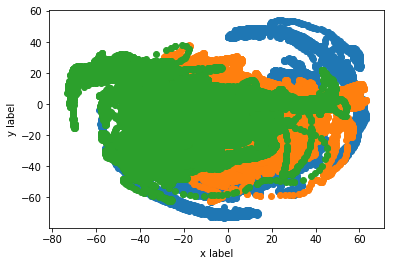

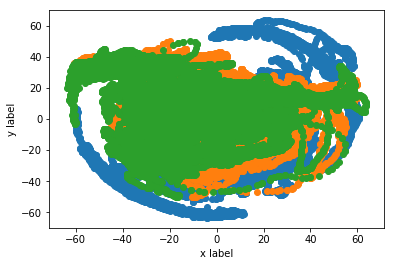

23
Output: tensor([-0.5819, -0.3843,  0.3692,  0.3625, -0.2100,  0.8586],
       grad_fn=<SelectBackward>)
True: tensor([-0.8468, -0.4228,  0.3228,  0.4546, -0.2599,  0.8519])
Loss: 0.015211110934615135

Output: tensor([-0.6032, -0.3858,  0.3748,  0.3480, -0.1937,  0.8386],
       grad_fn=<SelectBackward>)
True: tensor([-0.8468, -0.4228,  0.3228,  0.4546, -0.2599,  0.8519])
Loss: 0.014201861806213856

Output: tensor([-0.6159, -0.3839,  0.3746,  0.3317, -0.1960,  0.8242],
       grad_fn=<SelectBackward>)
True: tensor([-0.8468, -0.4228,  0.3228,  0.4546, -0.2599,  0.8519])
Loss: 0.013814300298690796

Output: tensor([-0.6226, -0.3927,  0.3653,  0.3228, -0.1977,  0.8139],
       grad_fn=<SelectBackward>)
True: tensor([-0.8468, -0.4228,  0.3228,  0.4546, -0.2599,  0.8519])
Loss: 0.013361029326915741

Output: tensor([-0.6222, -0.4227,  0.3437,  0.3261, -0.1907,  0.8060],
       grad_fn=<SelectBackward>)
True: tensor([-0.8468, -0.4228,  0.3228,  0.4546, -0.2599,  0.8519])
Loss: 0.012762122787

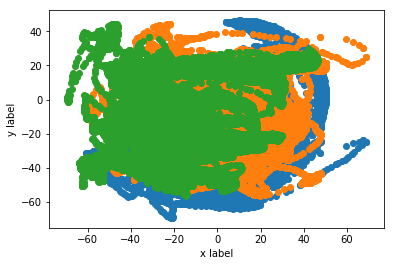

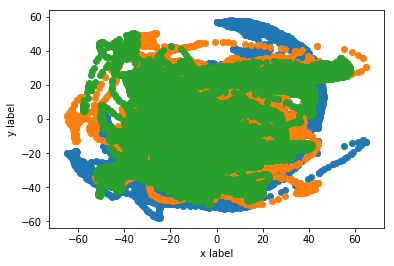

31
Output: tensor([ 0.2526,  0.8849, -0.1484, -0.3797,  0.2217,  0.8601],
       grad_fn=<SelectBackward>)
True: tensor([ 0.1063,  0.9909, -0.0832, -0.2870,  0.1107,  0.9515])
Loss: 0.010453514754772186

Output: tensor([ 0.2359,  0.8903, -0.1391, -0.3706,  0.2199,  0.8708],
       grad_fn=<SelectBackward>)
True: tensor([ 0.1063,  0.9909, -0.0832, -0.2870,  0.1107,  0.9515])
Loss: 0.008804591372609138

Output: tensor([ 0.2268,  0.8908, -0.1348, -0.3671,  0.2191,  0.8763],
       grad_fn=<SelectBackward>)
True: tensor([ 0.1063,  0.9909, -0.0832, -0.2870,  0.1107,  0.9515])
Loss: 0.008118820376694202

Output: tensor([ 0.2195,  0.8917, -0.1308, -0.3643,  0.2178,  0.8804],
       grad_fn=<SelectBackward>)
True: tensor([ 0.1063,  0.9909, -0.0832, -0.2870,  0.1107,  0.9515])
Loss: 0.007561341393738985

Output: tensor([ 0.2133,  0.8924, -0.1270, -0.3617,  0.2159,  0.8840],
       grad_fn=<SelectBackward>)
True: tensor([ 0.1063,  0.9909, -0.0832, -0.2870,  0.1107,  0.9515])
Loss: 0.007077059242

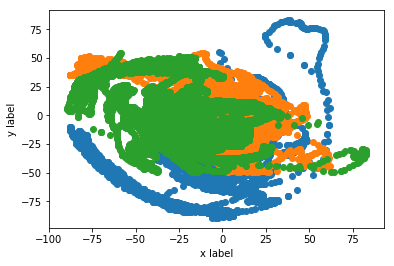

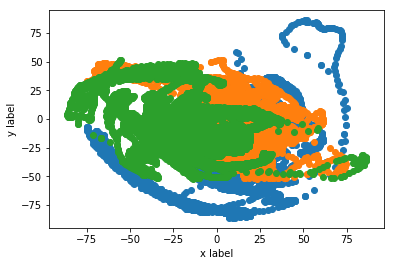

42
Output: tensor([-0.4610, -0.8527,  0.0308,  0.4398, -0.2087,  0.8554],
       grad_fn=<SelectBackward>)
True: tensor([-0.4549, -0.8905,  0.0024,  0.4569, -0.2311,  0.8590])
Loss: 0.000868465518578887

Output: tensor([-0.4673, -0.8497,  0.0349,  0.4381, -0.2074,  0.8544],
       grad_fn=<SelectBackward>)
True: tensor([-0.4549, -0.8905,  0.0024,  0.4569, -0.2311,  0.8590])
Loss: 0.0010067931143566966

Output: tensor([-0.4719, -0.8487,  0.0356,  0.4370, -0.2080,  0.8531],
       grad_fn=<SelectBackward>)
True: tensor([-0.4549, -0.8905,  0.0024,  0.4569, -0.2311,  0.8590])
Loss: 0.0010541797382757068

Output: tensor([-0.4748, -0.8481,  0.0356,  0.4364, -0.2085,  0.8522],
       grad_fn=<SelectBackward>)
True: tensor([-0.4549, -0.8905,  0.0024,  0.4569, -0.2311,  0.8590])
Loss: 0.0010773917892947793

Output: tensor([-0.4764, -0.8478,  0.0355,  0.4362, -0.2087,  0.8517],
       grad_fn=<SelectBackward>)
True: tensor([-0.4549, -0.8905,  0.0024,  0.4569, -0.2311,  0.8590])
Loss: 0.001087272

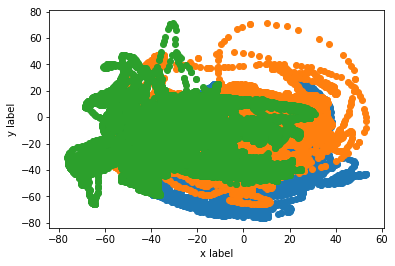

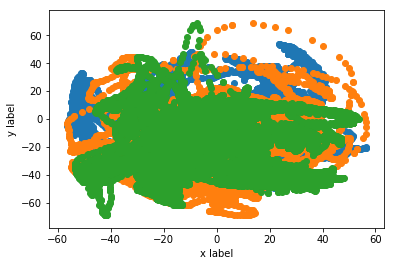

32
Output: tensor([ 0.4732,  0.7154,  0.4958, -0.4227, -0.1820,  0.7955],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4799,  0.6998,  0.5292, -0.6297, -0.1452,  0.7631])
Loss: 0.008316075429320335

Output: tensor([ 0.4613,  0.6940,  0.5169, -0.4314, -0.1790,  0.7766],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4799,  0.6998,  0.5292, -0.6297, -0.1452,  0.7631])
Loss: 0.007281474769115448

Output: tensor([ 0.4550,  0.6886,  0.5210, -0.4407, -0.1800,  0.7699],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4799,  0.6998,  0.5292, -0.6297, -0.1452,  0.7631])
Loss: 0.006680137477815151

Output: tensor([ 0.4511,  0.6875,  0.5222, -0.4470, -0.1817,  0.7667],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4799,  0.6998,  0.5292, -0.6297, -0.1452,  0.7631])
Loss: 0.00635313056409359

Output: tensor([ 0.4482,  0.6878,  0.5221, -0.4514, -0.1834,  0.7650],
       grad_fn=<SelectBackward>)
True: tensor([ 0.4799,  0.6998,  0.5292, -0.6297, -0.1452,  0.7631])
Loss: 0.0061585786752

In [26]:
lossVals = []
totalEpochs = 0
epochList = []

batch_size = 100
n_iters = 10000
#num_epochs = 1


for x in range(7):
    train, X, y = parseSheet(os.path.join("../Data", newFileNames[x], "Data.csv"), os.path.join("OriVectUsers/", outputFileNames[x]))
    
    num_epochs = n_iters / (len(X) / batch_size)
    num_epochs = int(num_epochs)

    print(num_epochs)

    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, drop_last=True, shuffle=False)
    
    for epoch in range(num_epochs): 
        totalEpochs += 1

        for X, y in train_loader:

            train = X.view(-1, 1, X.shape[1]).float()

            optimizer.zero_grad()

            outputs = rnn(train)

            loss = error(outputs, y)

            loss.backward()

            optimizer.step()

            count += 1
            
            # if count % 250 == 0:
            #
            #     correct = 0
            #     total = 0
            #
            #     for X, y in train_loader:
            #
            #         train = X.view(-1, 1, X.shape[1]).float()
            #
            #         outputs = rnn(train)

        lossVals.append(loss.data.item())
        print('Output:', outputs[0])
        print('True:', y[0])
        print('Loss:', loss.data.item())
        print()

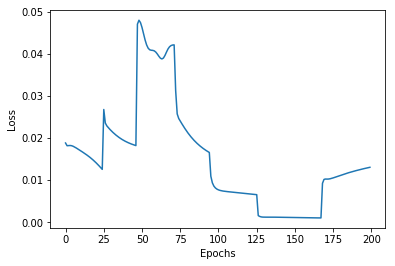

In [23]:
plt.plot([x for x in range(totalEpochs)], lossVals)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("loss_function.png")

In [ ]:
def calcLoss(test_X_fName, test_y_fName):
    
    test, test_X, test_y = parseSheet(os.path.join("../Data", test_X_fName, "Data.csv"), os.path.join("OriVectUsers/", test_y_fName))
    
    test_X = test_X.view(-1, 1, test_X.shape[1]).float()
    print(test_X.shape)
    outputs = rnn(test_X)
    
    loss = error(outputs, test_y)
    
    print(loss)

In [ ]:
calcLoss(test_X_fName, test_y_fName)